In [183]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
%autoreload

In [3]:
from santa_2022.original import *
import os

In [149]:
def check_positions(path):
    n = 128
    points = list(product(range(-n, n+1), repeat=2))
    points = set(points)
    
    path = set([get_position(c) for c in path])
    try:
        assert points == path
    except AssertionError:
        return points - path

def path_to_df(path):
    position = [get_position(config) for config in path]
    reconf_costs = [None] + [reconfiguration_cost(config, next_config) 
                                                 for config, next_config 
                                                 in zip(path, path[1:])]
    step_costs = [None] + [step_cost(config, next_config, image) 
                                      for config, next_config 
                                  in zip(path, path[1:])]
    return pd.DataFrame({"config": path,
                         "position": position,
                         "reconf_cost": reconf_costs,
                         "step_cost": step_costs,
                        })

def string_to_config(row_string):
    a = (pair.split() for pair in row_string.split(";"))
    b = ([int(x), int(y)] for (x, y) in a)
    return list(b)

# compress a path between two points
def compress_path(path):
    r = [[] for _ in range(8)]
    for p in path:
        for i in range(8):
            if len(r[i]) == 0 or r[i][-1] != p[i]:
                r[i].append(p[i])
    mx = max([len(x) for x in r])
    
    for rr in r:
        while len(rr) < mx:
            rr.append(rr[-1])
    r = list(zip(*r))
    for i in range(len(r)):
        r[i] = list(r[i])
    return r

def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])

def generate_submission(path, name):
    if name is None:
        raise ValueError("Please enter a filename")
    submission = pd.Series(
        [config_to_string(config) for config in path],
        name="configuration",
    )
    submission.head()
    submission.to_csv(f"../output/submissions/{name}.csv", index=False)

image = df_to_image(pd.read_csv("../data/image.csv"))

In [7]:

with open("../output/web_renders/test_path.json") as f:
    path = json.load(f)

len(path)

4805

In [8]:
duplicate_ids = [i+1 for i, (config, next_config) in enumerate(zip(path, path[1:])) if config == next_config]
len(duplicate_ids)

0

In [20]:
deduped_path = [config for i, config in enumerate(path) if i not in duplicate_ids]

0    64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1    64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 1
2     64 0;-32 0;-16 1;-8 0;-4 0;-2 0;-1 0;0 1
3    64 -1;-32 0;-16 1;-8 0;-4 0;-2 0;-1 0;1 1
4    64 -1;-32 0;-16 2;-8 0;-4 0;-2 0;-1 1;0 1
Name: configuration, dtype: object

In [22]:
submission.to_csv("output/submissions/pycharm_first.csv", index=False)

In [122]:
kaggle_submission = pd.read_csv("output/submissions/submission_online.csv").astype("string")
kaggle_submission.head()

online_path = [string_to_config(row) for row in kaggle_submission["configuration"]]

In [128]:
with open("output/web_renders/online_sub.json", "w") as file:
    file.write(json.dumps(online_path))

online_df = path_to_df(online_path)
online_df.head()

In [10]:
local_df = path_to_df(path)
local_df.head()

,config,position,reconf_cost,step_cost
0,"[[16, 0], [-8, 0], [-4, 0], [-2, 0], [-1, 0], ...","(0, 0)",NaN,NaN
1,"[[16, 0], [-8, 0], [-4, 0], [-2, 0], [-1, 0], ...","(0, -1)",1.0,1.094118
2,"[[16, 0], [-8, 0], [-4, 0], [-2, 0], [-1, 0], ...","(1, -1)",1.0,1.094118
3,"[[16, 0], [-8, 0], [-4, 0], [-2, 0], [-1, 0], ...","(2, -1)",1.0,1.035294
4,"[[16, 0], [-8, 1], [-4, 0], [-2, 0], [-1, 0], ...","(2, 0)",1.0,1.094118


In [5]:
import json

image = df_to_image(pd.read_csv("../data/image.csv"))

with open("../output/web_renders/improved_ordering_and_path_compression.json") as f:
    path = json.load(f)

imp_ord = path_to_df(path)

In [135]:
imp_ord.loc[(imp_ord["position"] == (128, -128)), :]

,config,position,reconf_cost,step_cost
96,"[[64, -64], [32, -32], [16, -16], [8, -8], [4,...","(128, -128)",1.0,1.552941


### We visit (0, -63) 33 times

In [44]:
imp_ord.loc[(imp_ord["position"] == (0, -63)), :]

,config,position,reconf_cost,step_cost
17161,"[[-64, -64], [32, 32], [16, -15], [8, -8], [4,...","(0, -63)",1.000000,1.011765
33810,"[[-64, -31], [32, 0], [16, -16], [8, -8], [4, ...","(0, -63)",1.732051,2.143816
33811,"[[-64, -30], [32, -1], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214
33812,"[[-64, -29], [32, -2], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214
33813,"[[-64, -28], [32, -3], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214
33814,"[[-64, -27], [32, -4], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214
33815,"[[-64, -26], [32, -5], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214
33816,"[[-64, -25], [32, -6], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214
33817,"[[-64, -24], [32, -7], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214
33818,"[[-64, -23], [32, -8], [16, -16], [8, -8], [4,...","(0, -63)",1.414214,1.414214


In [47]:
i = 17161
imp_ord.iloc[i-15:i+30, :]

,config,position,reconf_cost,step_cost
17146,"[[-64, -64], [17, 32], [16, -15], [8, -8], [4,...","(-15, -63)",1.0,1.764706
17147,"[[-64, -64], [18, 32], [16, -15], [8, -8], [4,...","(-14, -63)",1.0,1.129412
17148,"[[-64, -64], [19, 32], [16, -15], [8, -8], [4,...","(-13, -63)",1.0,2.200000
17149,"[[-64, -64], [20, 32], [16, -15], [8, -8], [4,...","(-12, -63)",1.0,2.164706
17150,"[[-64, -64], [21, 32], [16, -15], [8, -8], [4,...","(-11, -63)",1.0,1.823529
17151,"[[-64, -64], [22, 32], [16, -15], [8, -8], [4,...","(-10, -63)",1.0,1.082353
17152,"[[-64, -64], [23, 32], [16, -15], [8, -8], [4,...","(-9, -63)",1.0,1.176471
17153,"[[-64, -64], [24, 32], [16, -15], [8, -8], [4,...","(-8, -63)",1.0,1.011765
17154,"[[-64, -64], [25, 32], [16, -15], [8, -8], [4,...","(-7, -63)",1.0,1.576471
17155,"[[-64, -64], [26, 32], [16, -15], [8, -8], [4,...","(-6, -63)",1.0,1.635294


In [54]:
i = 33810
imp_ord.iloc[i-40:i+10, :]

,config,position,reconf_cost,step_cost
33770,"[[-64, -63], [24, 32], [16, 16], [8, 8], [4, 4...","(-8, 1)",1.000000,2.705882
33771,"[[-64, -63], [25, 32], [16, 16], [8, 8], [4, 4...","(-7, 1)",1.000000,1.129412
33772,"[[-64, -63], [26, 32], [16, 16], [8, 8], [4, 4...","(-6, 1)",1.000000,1.305882
33773,"[[-64, -63], [27, 32], [16, 16], [8, 8], [4, 4...","(-5, 1)",1.000000,1.152941
33774,"[[-64, -63], [28, 32], [16, 16], [8, 8], [4, 4...","(-4, 1)",1.000000,1.576471
33775,"[[-64, -63], [29, 32], [16, 16], [8, 8], [4, 4...","(-3, 1)",1.000000,1.835294
33776,"[[-64, -63], [30, 32], [16, 16], [8, 8], [4, 4...","(-2, 1)",1.000000,2.023529
33777,"[[-64, -63], [31, 32], [16, 16], [8, 8], [4, 4...","(-1, 1)",1.000000,1.776471
33778,"[[-64, -63], [32, 32], [16, 16], [8, 8], [4, 4...","(0, 1)",1.000000,1.435294
33779,"[[-64, -62], [32, 31], [16, 15], [8, 7], [4, 3...","(0, -5)",2.828427,3.663721


In [59]:
i = 33841
imp_ord.iloc[i+25:i+90, :]

,config,position,reconf_cost,step_cost
33866,"[[-64, 25], [32, -31], [16, -16], [8, -8], [4,...","(0, -38)",1.0,1.341176
33867,"[[-64, 26], [32, -31], [16, -16], [8, -8], [4,...","(0, -37)",1.0,1.247059
33868,"[[-64, 27], [32, -31], [16, -16], [8, -8], [4,...","(0, -36)",1.0,1.258824
33869,"[[-64, 28], [32, -31], [16, -16], [8, -8], [4,...","(0, -35)",1.0,1.247059
33870,"[[-64, 29], [32, -31], [16, -16], [8, -8], [4,...","(0, -34)",1.0,1.364706
...,...,...,...,...
33926,"[[-43, 64], [32, -31], [16, -16], [8, -8], [4,...","(21, 1)",1.0,2.235294
33927,"[[-42, 64], [32, -31], [16, -16], [8, -8], [4,...","(22, 1)",1.0,2.788235
33928,"[[-41, 64], [32, -31], [16, -16], [8, -8], [4,...","(23, 1)",1.0,1.752941
33929,"[[-40, 64], [32, -31], [16, -16], [8, -8], [4,...","(24, 1)",1.0,1.200000


In [107]:
imp_ord["position"].value_counts().value_counts()

1     65129
2       723
3       180
5         8
9         4
17        2
4         2
33        1
Name: position, dtype: int64

In [50]:
imp_ord["step_cost"].sum()

82409.67721737362

In [74]:
imp_ord.iloc[33778, 0]

[[-64, -63], [32, 32], [16, 16], [8, 8], [4, 4], [2, 2], [1, 1], [1, 1]]

In [76]:
conf = [[-64, -63], [32, 32], [16, 16], [8, 8], [4, 4], [2, 2], [1, 1], [1, 1]]
print(get_position(conf))
point = (0, 2)

len(get_path_to_point(conf, point))

In [137]:
vc = imp_ord["position"].value_counts()
vc

(0, -63)       33
(-64, 33)      17
(-64, -95)     17
(-96, -111)     9
(-96, 81)       9
               ..
(46, -42)       1
(45, -42)       1
(44, -42)       1
(43, -42)       1
(-128, 128)     1
Name: position, Length: 66049, dtype: int64

In [128]:
doubles = vc[vc==2]
doubles

(128, -38)     2
(0, 58)        2
(0, 40)        2
(-120, -90)    2
(-128, -89)    2
              ..
(-44, 64)      2
(-96, 97)      2
(6, -24)       2
(-96, -31)     2
(-21, 64)      2
Name: position, Length: 723, dtype: int64

In [131]:
imp_ord.loc[imp_ord["position"].isin(doubles.index), :].sort_values(by="position")

,config,position,reconf_cost,step_cost
869,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -125)",1.000000,1.000000
870,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -125)",1.414214,1.414214
1904,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -121)",1.414214,1.414214
1903,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -121)",1.000000,1.011765
3977,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -113)",1.414214,1.414214
...,...,...,...,...
64228,"[[64, 64], [32, 32], [16, 16], [8, 8], [4, -4]...","(128, 118)",1.414214,1.414214
65266,"[[64, 64], [32, 32], [16, 16], [8, 8], [4, 4],...","(128, 122)",1.414214,1.414214
65265,"[[64, 64], [32, 32], [16, 16], [8, 8], [4, 4],...","(128, 122)",1.000000,1.000000
66300,"[[64, 64], [32, 32], [16, 16], [8, 8], [4, 4],...","(128, 126)",1.000000,1.011765


In [134]:
imp_ord.iloc[867:, :]

,config,position,reconf_cost,step_cost
867,"[[-63, -64], [-32, -32], [-16, -16], [-8, -8],...","(-127, -126)",1.000000,1.035294
868,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -126)",1.000000,1.870588
869,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -125)",1.000000,1.000000
870,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-128, -125)",1.414214,1.414214
871,"[[-64, -64], [-32, -32], [-16, -16], [-8, -8],...","(-127, -125)",1.000000,1.870588
...,...,...,...,...
67261,"[[64, 4], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 4)",1.000000,1.694118
67262,"[[64, 3], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 3)",1.000000,1.729412
67263,"[[64, 2], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 2)",1.000000,1.494118
67264,"[[64, 1], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 1)",1.000000,1.294118


In [144]:
s = imp_ord["step_cost"].value_counts().reset_index()

In [149]:
s.loc[s["index"] < sqrt(2) + 0.00000001, "step_cost"].sum()

55926

In [95]:
imp_ord.iloc[95:, :]

,config,position,reconf_cost,step_cost
95,"[[64, -64], [31, -32], [16, -16], [8, -8], [4,...","(127, -128)",1.0,1.035294
96,"[[64, -64], [32, -32], [16, -16], [8, -8], [4,...","(128, -128)",1.0,1.552941
97,"[[64, -64], [32, -32], [16, -16], [8, -8], [4,...","(127, -128)",1.0,1.552941
98,"[[64, -64], [32, -32], [16, -16], [8, -8], [4,...","(126, -128)",1.0,1.035294
99,"[[64, -64], [32, -32], [16, -16], [8, -8], [4,...","(125, -128)",1.0,1.000000
...,...,...,...,...
67261,"[[64, 4], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 4)",1.0,1.694118
67262,"[[64, 3], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 3)",1.0,1.729412
67263,"[[64, 2], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 2)",1.0,1.494118
67264,"[[64, 1], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 1)",1.0,1.294118


##### compressed path doesn't find all 1 step options

In [96]:
imp_ord.iloc[96, 0]

[[64, -64], [32, -32], [16, -16], [8, -8], [4, -4], [2, -2], [1, -1], [1, -1]]

In [102]:
c = [[64, -64], [32, -32], [16, -16], [8, -8], [4, -4], [2, -2], [1, -1], [1, -1]]
point = (126, -128)
compress_path(get_path_to_point(c, point))

[[[64, -64],
  [32, -32],
  [16, -16],
  [8, -8],
  [4, -4],
  [2, -2],
  [1, -1],
  [1, -1]],
 [[64, -64],
  [32, -32],
  [16, -16],
  [8, -8],
  [4, -4],
  [2, -2],
  [1, -1],
  (0, -1)],
 [[64, -64],
  [32, -32],
  [16, -16],
  [8, -8],
  [4, -4],
  [2, -2],
  [1, -1],
  (-1, -1)]]

In [121]:
cand = [[64, -64], [32, -32], [16, -16], [8, -8], [4, -4], [2, -2], [0, -1], [0, -1]]
compress_path(get_path_to_point(cand, (125, -128)))

[[[64, -64],
  [32, -32],
  [16, -16],
  [8, -8],
  [4, -4],
  [2, -2],
  [0, -1],
  [0, -1]],
 [[64, -64],
  [32, -32],
  [16, -16],
  [8, -8],
  [4, -4],
  [2, -2],
  [0, -1],
  (-1, -1)]]

### circular path

In [103]:
import json

image = df_to_image(pd.read_csv("../data/image.csv"))

with open("../output/web_renders/circular_ordering_and_path_compression.json") as f:
    path = json.load(f)

circ = path_to_df(path)

In [104]:
circ

,config,position,reconf_cost,step_cost
0,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 0)",NaN,NaN
1,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, -1)",1.0,1.094118
2,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, -2)",1.0,1.176471
3,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, -3)",1.0,1.188235
4,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, -4)",1.0,1.200000
...,...,...,...,...
67712,"[[64, -4], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -4)",1.0,1.282353
67713,"[[64, -3], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -3)",1.0,1.200000
67714,"[[64, -2], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -2)",1.0,1.188235
67715,"[[64, -1], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -1)",1.0,1.176471


In [106]:
circ["position"].value_counts().value_counts()

1     64867
2       846
3       307
5        16
9         8
17        5
Name: position, dtype: int64

### Optimal way to get from origin to bottom right corner
Takes atleast 96 steps because of second link

[([(3, -4), (1, -2), (1, -1), (1, -1)], (6, -8), 1.6965665035495654),
 ([(3, -4), (2, -2), (0, -1), (1, -1)], (6, -8), 1.6965665035495654),
 ([(3, -4), (2, -2), (1, -1), (0, -1)], (6, -8), 1.6965665035495654),
 ([(4, -4), (1, -2), (0, -1), (1, -1)], (6, -8), 1.6965665035495654),
 ([(4, -4), (1, -2), (1, -1), (0, -1)], (6, -8), 1.6965665035495654),
 ([(4, -4), (2, -2), (0, -1), (0, -1)], (6, -8), 1.6965665035495654)]

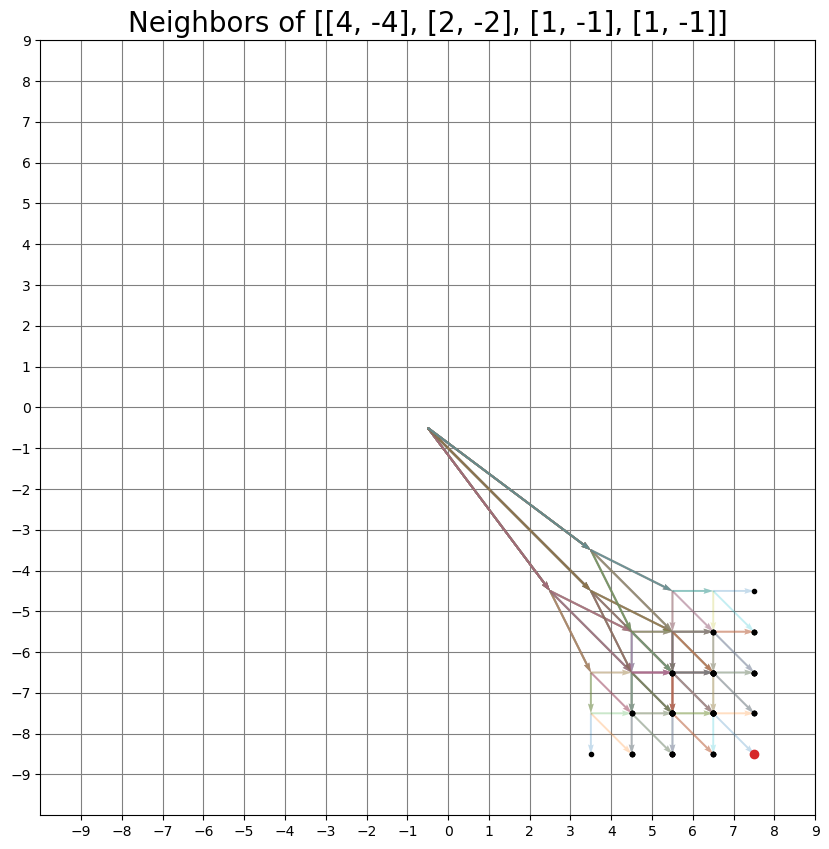

In [117]:
from santa_2022.plotting import *

c = [[4, -4], [2, -2], [1, -1], [1, -1]]
neigh = get_neighbors(c)
pos = [get_position(n) for n in neigh]
costs = [step_cost(c, n, image) for n in neigh]
plot_neighbors(c)
list(filter(lambda x: x[1] == (6, -8), zip(neigh, pos, costs)))

<AxesSubplot: title={'center': 'Neighbors of [[4, 0], [-2, 0], [-1, 0], [-1, 0]]'}>

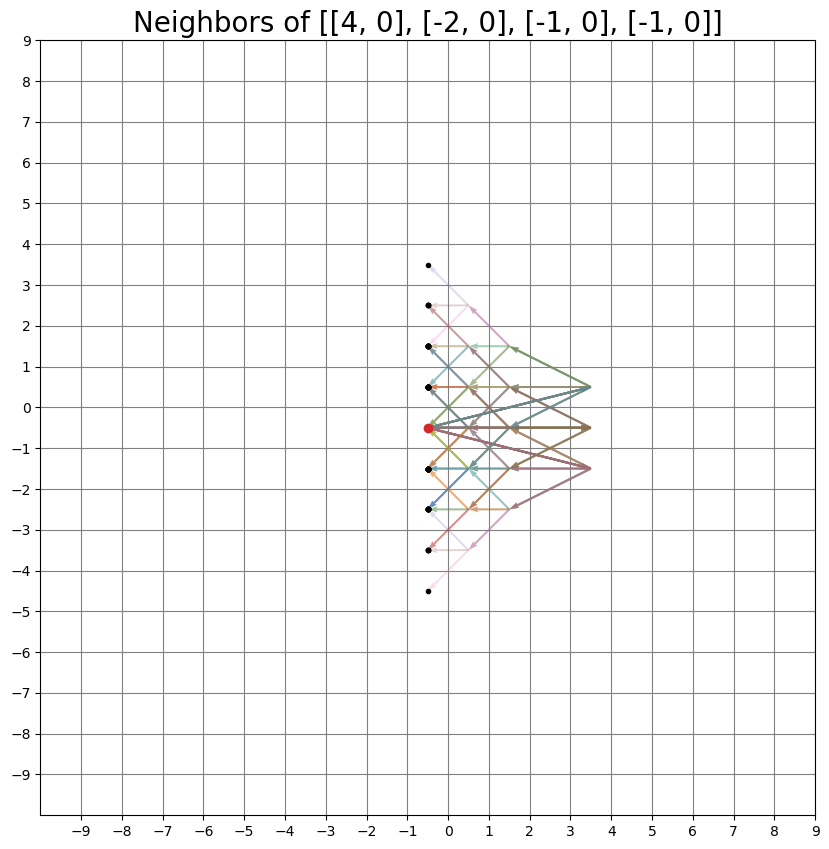

In [122]:
c = [[4, 0], [-2, 0], [-1, 0], [-1, 0]]
plot_neighbors(c)

<AxesSubplot: title={'center': 'Neighbors of [[4, -1], [-2, -1], [-1, -1], [-1, -1]]'}>

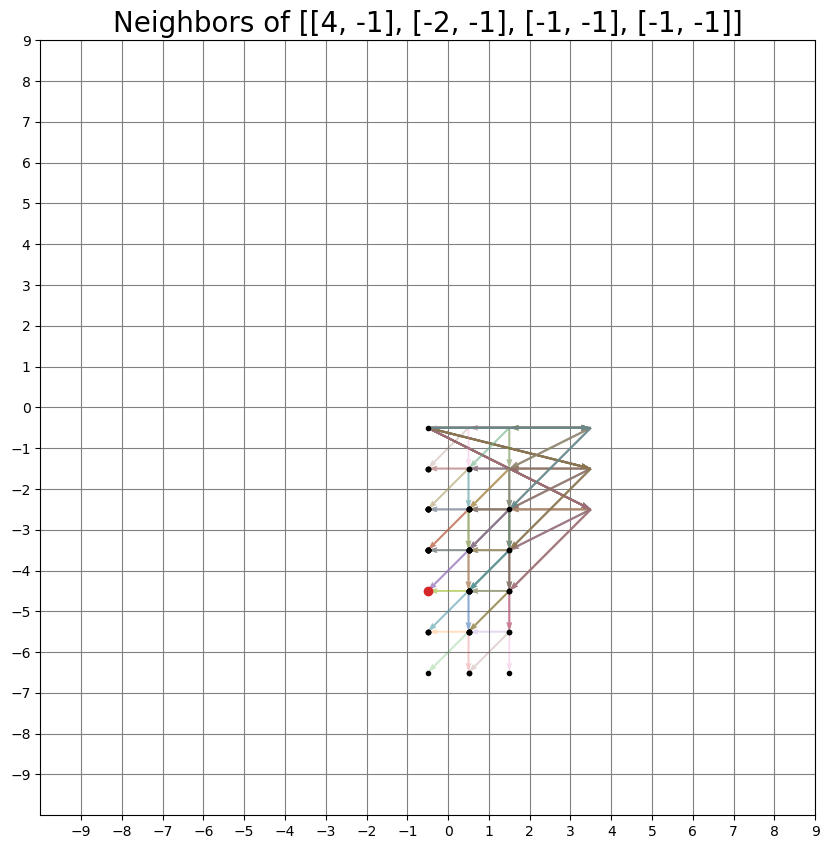

In [123]:
c = [[4, -1], [-2, -1], [-1, -1], [-1, -1]]
plot_neighbors(c)

In [124]:
c = [[4, -1], [-2, -1], [-1, -1], [-1, -1]]
[n for n in get_neighbors(c) if get_position(n) == (2, -6)]

[[(4, -2), (-2, -2), (0, -1), (0, -1)]]

<AxesSubplot: title={'center': 'Neighbors of [(4, -2), (-2, -2), (0, -1), (0, -1)]'}>

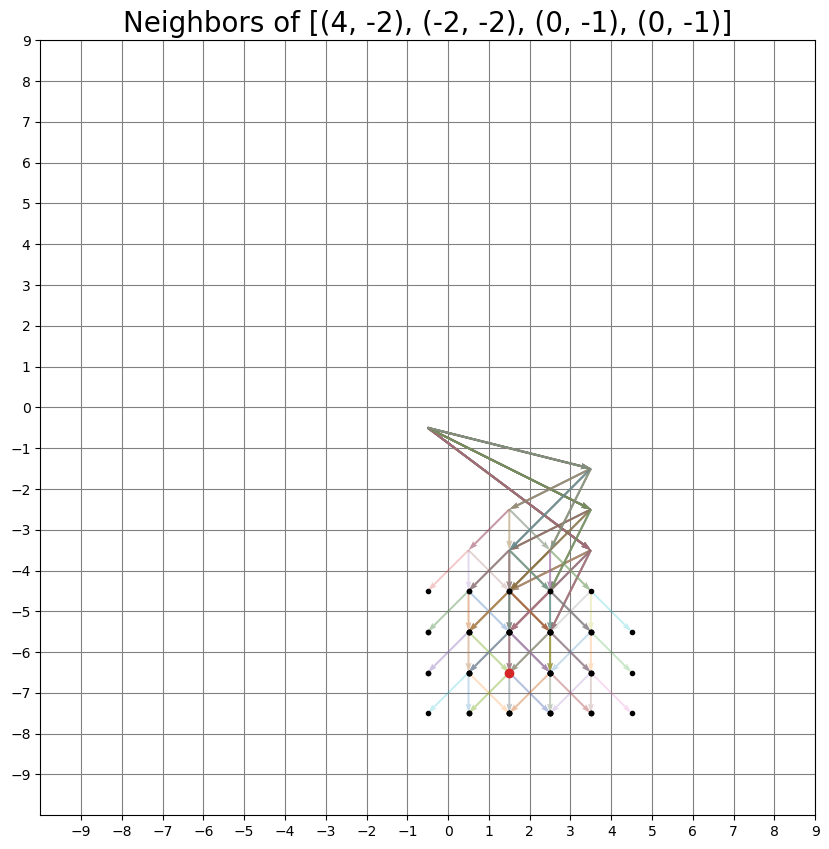

In [126]:
c = [(4, -2), (-2, -2), (0, -1), (0, -1)]
plot_neighbors(c)

In [127]:
c = [(4, -2), (-2, -2), (0, -1), (0, -1)]
[n for n in get_neighbors(c) if get_position(n) == (5, -7)]

[[(4, -3), (-1, -2), (1, -1), (1, -1)]]

### Optimize greedy path via log file

In [8]:
import json

with open("../output/web_renders/path2022-12-19 02:03:16.714100.json", "r") as file:
    path = json.load(file)
    
len(path)

71589

In [9]:
df = path_to_df(path)
df

,config,position,reconf_cost,step_cost
0,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 0)",NaN,NaN
1,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, -1)",1.0,1.094118
2,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(1, -1)",1.0,1.094118
3,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(2, -1)",1.0,1.035294
4,"[[64, 0], [-32, 1], [-16, 0], [-8, 0], [-4, 0]...","(2, 0)",1.0,1.094118
...,...,...,...,...
71584,"[[64, -4], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -4)",1.0,1.282353
71585,"[[64, -3], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -3)",1.0,1.200000
71586,"[[64, -2], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -2)",1.0,1.188235
71587,"[[64, -1], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -1)",1.0,1.176471


In [71]:
check_positions(df.iloc[:71391, 1].to_list())

In [72]:
df.iloc[71390:71400, :]

,config,position,reconf_cost,step_cost
71390,"[[-64, -58], [-32, 30], [-16, -16], [-8, 1], [...","(-123, -36)",1.414214,1.437743
71391,"[[-64, -59], [-32, 29], [-16, -15], [-8, 0], [...","(-126, -37)",2.828427,2.840192
71392,"[[-64, -60], [-32, 28], [-16, -14], [-8, 0], [...","(-127, -41)",2.645751,2.692810
71393,"[[-64, -61], [-32, 27], [-16, -13], [-8, 0], [...","(-128, -44)",2.449490,3.637725
71394,"[[-64, -62], [-32, 26], [-16, -12], [-8, 0], [...","(-128, -47)",2.236068,2.271362
71395,"[[-64, -63], [-32, 25], [-16, -11], [-8, 0], [...","(-128, -49)",2.000000,2.023529
71396,"[[-64, -64], [-32, 24], [-16, -10], [-8, 0], [...","(-128, -50)",1.732051,1.743816
71397,"[[-63, -64], [-32, 23], [-16, -9], [-8, 0], [-...","(-127, -50)",1.732051,2.849698
71398,"[[-62, -64], [-32, 22], [-16, -8], [-8, 0], [-...","(-126, -50)",1.732051,1.802639
71399,"[[-61, -64], [-32, 21], [-16, -7], [-8, 0], [-...","(-125, -50)",1.732051,1.743816


In [20]:
display(df["step_cost"].sum())

display((df["reconf_cost"] == 0.0).sum())

display(df["position"].value_counts().value_counts())

pos = df["position"].to_list()
pos = set(pos)

n = 128
points = list(product(range(-n, n+1), repeat=2))
points = set(points)

assert pos == points

In [106]:
from ast import literal_eval

with open("../logging/2022-12-16 00:18:57.534404.log") as file:
    log_info = []
    log_info.append((0, "start", 0, (0, 0)))
    steps = 0

    while True:
        first = file.readline()
        if first == "":
            break
        first = first.partition("DEBUG")[2].strip()
        
        try:
            i = int(first.split()[0])
        except ValueError:
            i += 1

        t = None
        if "cheapest" in first:
            t = "cheapest"
            s = 1
            steps += s
        elif "two_steps" in first:
            t = "two"
            s = 2
            steps += s
        elif "slow path" in first:
            t = "slow"
            s = int(first.split()[-2])
            steps += s
        elif "before going to origin:" in first:
            continue
        elif "after going to origin:" in first:
            t = "ending"
            s = int(first.split()[-1]) - 1
            log_info.append((0, t, s, (0, 0)))
            continue
        else:
            print("unreachable")
            print(first)
            raise ValueError
        second = file.readline()
        second = second.partition("DEBUG")[2].strip()
        idx = second.find("(")-1
        assert idx != - 2
        pos = literal_eval(second[idx:])
        log_info.append((s, t, steps, pos))
        
len(log_info)

66050

In [76]:
len(log_info)

66050

In [77]:
log_df

,s,type,steps,visited
0,0,start,0,"(0, 0)"
1,1,cheapest,1,"(0, -1)"
2,1,cheapest,2,"(1, -1)"
3,1,cheapest,3,"(2, -1)"
4,1,cheapest,4,"(2, 0)"
...,...,...,...,...
66045,1,cheapest,71387,"(-126, -35)"
66046,1,cheapest,71388,"(-126, -34)"
66047,1,cheapest,71389,"(-123, -34)"
66048,1,cheapest,71390,"(-123, -36)"


In [133]:
log_df.loc[log_df["type"]=="slow", :]

,s,type,steps,visited
30189,13,slow,30222,"(87, 83)"
30222,3,slow,30258,"(90, 92)"
33845,6,slow,33905,"(-118, -79)"
33920,13,slow,33992,"(-115, -90)"
39091,6,slow,39181,"(64, -70)"
...,...,...,...,...
65948,12,slow,71236,"(-99, -47)"
65961,3,slow,71253,"(-110, -51)"
65963,3,slow,71257,"(-113, -53)"
66042,18,slow,71357,"(-123, -60)"


In [92]:
log_df.loc[log_df["type"]=="slow", "s"].count()

317

In [132]:
log_df.iloc[30253:, :]

,s,type,steps,visited
30253,1,cheapest,30289,"(104, 92)"
30254,1,cheapest,30290,"(104, 91)"
30255,1,cheapest,30291,"(105, 91)"
30256,1,cheapest,30292,"(106, 91)"
30257,1,cheapest,30293,"(106, 90)"
...,...,...,...,...
66045,1,cheapest,71387,"(-126, -35)"
66046,1,cheapest,71388,"(-126, -34)"
66047,1,cheapest,71389,"(-123, -34)"
66048,1,cheapest,71390,"(-123, -36)"


In [100]:
df.iloc[71390, :]

config         [[-64, -58], [-32, 30], [-16, -16], [-8, 1], [...
position                                             (-123, -36)
reconf_cost                                             1.414214
step_cost                                               1.437743
Name: 71390, dtype: object

In [102]:
df.iloc[71588, :]

config         [[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...
position                                                  (0, 0)
reconf_cost                                                  1.0
step_cost                                               1.094118
Name: 71588, dtype: object

In [104]:
path[30222]

[[64, 19], [32, 32], [7, 16], [-8, 8], [-4, 4], [-2, 2], [-1, 1], [-1, 1]]

In [84]:
log_info[:5]

[(0, 'start', 0, (0, 0)),
 (1, 'cheapest', 1, (0, -1)),
 (1, 'cheapest', 2, (1, -1)),
 (1, 'cheapest', 3, (2, -1)),
 (1, 'cheapest', 4, (2, 0))]

In [111]:
opt_idxs[:1]

[(30209, 30222)]

In [112]:
path[opt_idxs[0][0]]

[[64, 14], [32, 32], [14, 16], [-7, 8], [-4, 4], [-2, 2], [-1, 1], [-1, 1]]

In [114]:
df.iloc[30209, :]

config         [[64, 14], [32, 32], [14, 16], [-7, 8], [-4, 4...
position                                                (95, 78)
reconf_cost                                             1.414214
step_cost                                                1.75539
Name: 30209, dtype: object

In [115]:
df.iloc[30222, :]

config         [[64, 19], [32, 32], [7, 16], [-8, 8], [-4, 4]...
position                                                (87, 83)
reconf_cost                                                  1.0
step_cost                                               4.988235
Name: 30222, dtype: object

In [113]:
get_position(path[opt_idxs[0][0]])

(95, 78)

In [118]:
n = 1
uncompressed_path = path.copy()
for start_idx, stop_idx in opt_idxs[:n]:
    compression_candidate = uncompressed_path[start_idx:stop_idx+1]
    comp = compress_path(compression_candidate)
    extension = comp[1:]
    print(len(compression_candidate), (len(comp)))
    print(get_position(comp[0]))
    print(get_position(comp[-1]))

14 8
(95, 78)
(87, 83)


In [140]:
opt_idxs = [(log_info[i-1][2], log_info[i][2]) for i in range(len(log_info)) if log_info[i][1] == "slow"]
opt_idxs.append((log_info[-2][2], log_info[-1][2]))

opt_d = {start: stop for start, stop in opt_idxs}
opt_d

uncompressed_path = path.copy()
new_path = []
l = len(uncompressed_path)
i = 0
while i < l:
    if i not in opt_d:
        new_path.append(uncompressed_path[i])
        i += 1
    else:
        start = i
        stop = opt_d[i]
        assert start < stop
        original_path = uncompressed_path[start:stop+1]
        comp = compress_path(original_path)
        new_path.extend(comp)
        i = stop+1
len(new_path)

69654

In [141]:
check_positions(new_path)

In [142]:
new_df = path_to_df(new_path)

In [143]:
new_df

,config,position,reconf_cost,step_cost
0,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, 0)",NaN,NaN
1,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(0, -1)",1.0,1.094118
2,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(1, -1)",1.0,1.094118
3,"[[64, 0], [-32, 0], [-16, 0], [-8, 0], [-4, 0]...","(2, -1)",1.0,1.035294
4,"[[64, 0], [-32, 1], [-16, 0], [-8, 0], [-4, 0]...","(2, 0)",1.0,1.094118
...,...,...,...,...
69649,"[[64, -4], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -4)",1.0,1.282353
69650,"[[64, -3], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -3)",1.0,1.200000
69651,"[[64, -2], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -2)",1.0,1.188235
69652,"[[64, -1], [-32, 0], [-16, 0], [-8, 0], [-4, 0...","(0, -1)",1.0,1.176471


In [145]:
(df["reconf_cost"] == 0.0).sum()

0

In [144]:
new_df["step_cost"].sum()

83781.68632168122

In [146]:
df["step_cost"].sum()

85307.98481871549

In [137]:
len(path)

71589

In [138]:
for i, (old, new) in enumerate(zip(path, new_path)):
    try:
        assert old == new
    except AssertionError:
        print(i)
        raise

30209


AssertionError: 

In [150]:
generate_submission(new_path, "optimized_two_step")